<figure>
<center> 
<h1><b>Evaluasi Akhir Semester Kapsel ILKOM</b></h1>
</center>
<h2>Anggota Kelompok : 
<ol>
  <li>Sakia Rizkiana Putri (06111640000015)</li>
  <li>Ario Fajar Pratama (06111640000087)</li>
  <li>Kharisma Nur Fitriani (06111640000092)</li>
  <li>Anggi Nurinda Pratiwi (06111640000116)</li>
</ol>  </h2>
<center>
  <img src='https://covid19.kemkes.go.id/wp-content/uploads/2020/04/banner.png'/> </center>
</figure>


# <h2><b><i>Import Library</i> yang diperlukan dalam program ini</b></h2>

In [0]:
# Packages / libraries
import os 
import numpy as np 
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import datetime    
import random
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from math import sqrt
from datetime import datetime
from jinja2 import Template
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from fbprophet import Prophet


%matplotlib inline

# Mengubah angka Scientific ke float
#np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# meningkatkan ukuran dari sns plots
#sns.set(rc={'figure.figsize':(12,10)})

# <h2>Mengimport Data COVID-19 yang dapat diunduh di <a href="https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series"> <i>Link</i> ini </a></h2>

In [0]:
# Mendeklarasikan beberapa fungsi yang dibutuhkan seperti fungsi untuk menambah Benua

base_url = 'https://raw.githubusercontent.com/pratapvardhan/notebooks/master/covid19/'
paths = {
    'mapping': base_url + 'mapping_countries.csv',
    'overview': base_url + 'overview.tpl'
}

def get_mappings(url):
    df = pd.read_csv(url)
    return {
        'df': df,
        'replace.country': dict(df.dropna(subset=['Name']).set_index('Country')['Name']),
        'map.continent': dict(df.set_index('Name')['Continent'])
    }

mapping = get_mappings(paths['mapping'])

def get_template(path):
    from urllib.parse import urlparse
    if bool(urlparse(path).netloc):
        from urllib.request import urlopen
        return urlopen(path).read().decode('utf8')
    return open(path).read()

def get_frame(name):
    url = (
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
        f'csse_covid_19_time_series/time_series_covid19_{name}_global.csv')
    df = pd.read_csv(url)
    # rename countries
    df['Country/Region'] = df['Country/Region'].replace(mapping['replace.country'])
    return df

def get_dates(df):
    dt_cols = df.columns[~df.columns.isin(['Province/State', 'Country/Region', 'Lat', 'Long'])]
    LAST_DATE_I = -1
    # sometimes last column may be empty, then go backwards
    for i in range(-1, -len(dt_cols), -1):
        if not df[dt_cols[i]].fillna(0).eq(0).all():
            LAST_DATE_I = i
            break
    return LAST_DATE_I, dt_cols

In [158]:
# Memuat Data mentah
data_mentah_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
data_mentah_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
data_mentah_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

# Menampilkan ukuran dari data mentah di atas
print("Ukuran Data Confirmed Adalah : ", data_mentah_confirmed.shape, "--> (Baris, Kolom)")
print("Ukuran Data Deaths Adalah    : ", data_mentah_deaths.shape, "--> (Baris, Kolom)")
print("Ukuran Data Recovered Adalah : ", data_mentah_recovered.shape, "--> (Baris, Kolom)")

Ukuran Data Confirmed Adalah :  (266, 131) --> (Baris, Kolom)
Ukuran Data Deaths Adalah    :  (266, 131) --> (Baris, Kolom)
Ukuran Data Recovered Adalah :  (253, 131) --> (Baris, Kolom)


In [159]:
# Menampilkan Salah satu Data Mentah di atas, yaitu Data Mentah Confirmed
#pd.set_option('display.max_rows', None)
data_mentah_confirmed

Province/State         Country/Region        Lat  ...  5/25/20  5/26/20  5/27/20
0              NaN            Afghanistan  33.000000  ...    11173    11831    12456
1              NaN                Albania  41.153300  ...     1004     1029     1050
2              NaN                Algeria  28.033900  ...     8503     8697     8857
3              NaN                Andorra  42.506300  ...      763      763      763
4              NaN                 Angola -11.202700  ...       70       70       71
..             ...                    ...        ...  ...      ...      ...      ...
261            NaN  Sao Tome and Principe   0.186360  ...      299      441      443
262            NaN                  Yemen  15.552727  ...      233      249      256
263            NaN                Comoros -11.645500  ...       87       87       87
264            NaN             Tajikistan  38.861034  ...     3100     3266     3424
265            NaN                Lesotho -29.609988  ...        2        2        2

[266 rows x 131 columns]

# <h2><b>Mengubah ukuran dari Data Mentah di atas</b></h2>

In [160]:
# Menentukan Kolom fitur dari data mentah
fitur = ['Province/State', 'Country/Region', 'Lat', 'Long']

# Mengubah ukuran dari data tabel mentah dan menambahkan kolom secara berturut-turut 'Confirmed', 'Deaths', dan 'Recovered' 
# pada masing-masing Data
data_pivot_confirmed = pd.melt(data_mentah_confirmed, id_vars=fitur, var_name=['Date'], value_name ='Confirmed')
data_pivot_deaths = pd.melt(data_mentah_deaths, id_vars=fitur, var_name=['Date'], value_name ='Deaths')
data_pivot_recovered = pd.melt(data_mentah_recovered, id_vars=fitur, var_name=['Date'], value_name ='Recovered')

# Menampilkan ukuran dari data tabel mentah yang sudah diubah ukurannya
print("Ukuran data Confirmed menjadi :", data_pivot_confirmed.shape, "--> (Baris, Kolom)")
print("Ukuran data Deaths menjadi    :", data_pivot_deaths.shape, "--> (Baris, Kolom)")
print("Ukuran data Recovered menjadi :", data_pivot_recovered.shape, "--> (Baris, Kolom)")

Ukuran data Confirmed menjadi : (33782, 6) --> (Baris, Kolom)
Ukuran data Deaths menjadi    : (33782, 6) --> (Baris, Kolom)
Ukuran data Recovered menjadi : (32131, 6) --> (Baris, Kolom)


In [161]:
# Menampilkan Salah satu hasil Data Mentah yang telah diubah ukurannya, yaitu Data Pivot Confirmed
data_pivot_confirmed

Province/State         Country/Region  ...     Date  Confirmed
0                NaN            Afghanistan  ...  1/22/20          0
1                NaN                Albania  ...  1/22/20          0
2                NaN                Algeria  ...  1/22/20          0
3                NaN                Andorra  ...  1/22/20          0
4                NaN                 Angola  ...  1/22/20          0
...              ...                    ...  ...      ...        ...
33777            NaN  Sao Tome and Principe  ...  5/27/20        443
33778            NaN                  Yemen  ...  5/27/20        256
33779            NaN                Comoros  ...  5/27/20         87
33780            NaN             Tajikistan  ...  5/27/20       3424
33781            NaN                Lesotho  ...  5/27/20          2

[33782 rows x 6 columns]

# <h2><b>Mengganti format data pada kolom 'Date' menjadi format datetime (yyyy-dd-mm)</b></h2>

In [162]:
# Mengubah format pada kolom 'Date' menjadi format datetime (yyyy-dd-mm)
data_pivot_confirmed['Date'] = pd.to_datetime(data_pivot_confirmed['Date'])
data_pivot_deaths['Date'] = pd.to_datetime(data_pivot_deaths['Date'])
data_pivot_recovered['Date'] = pd.to_datetime(data_pivot_recovered['Date'])

# Menampilkan salah satu data yaitu Data Confirmed setelah format pada kolom 'Date' diganti
data_pivot_confirmed

Province/State         Country/Region  ...       Date  Confirmed
0                NaN            Afghanistan  ... 2020-01-22          0
1                NaN                Albania  ... 2020-01-22          0
2                NaN                Algeria  ... 2020-01-22          0
3                NaN                Andorra  ... 2020-01-22          0
4                NaN                 Angola  ... 2020-01-22          0
...              ...                    ...  ...        ...        ...
33777            NaN  Sao Tome and Principe  ... 2020-05-27        443
33778            NaN                  Yemen  ... 2020-05-27        256
33779            NaN                Comoros  ... 2020-05-27         87
33780            NaN             Tajikistan  ... 2020-05-27       3424
33781            NaN                Lesotho  ... 2020-05-27          2

[33782 rows x 6 columns]

# <h2><b>Mengatasi Cell pada tiap data yang bernilai Null atau NaN</b></h2>

In [163]:
# Menyelidiki dan menampilkan semua data pada tiap kolom yang bernilai null
print("DATA CONFIRMED\n", data_pivot_confirmed.isnull().sum())
print("\nDATA DEATHS\n", data_pivot_deaths.isnull().sum())
print("\nDATA RECOVERED\n", data_pivot_recovered.isnull().sum())

DATA CONFIRMED
 Province/State    23495
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
dtype: int64

DATA DEATHS
 Province/State    23495
Country/Region        0
Lat                   0
Long                  0
Date                  0
Deaths                0
dtype: int64

DATA RECOVERED
 Province/State    23622
Country/Region        0
Lat                   0
Long                  0
Date                  0
Recovered             0
dtype: int64


In [164]:
# Mengatasi nilai null pada kolom 'Province/State' dengan cara mengisi cell tsb dengan isi cell pada kolom 'Country/Region'
data_pivot_confirmed['Province/State'].fillna(data_pivot_confirmed['Country/Region'], inplace=True)
data_pivot_deaths['Province/State'].fillna(data_pivot_deaths['Country/Region'], inplace=True)
data_pivot_recovered['Province/State'].fillna(data_pivot_recovered['Country/Region'], inplace=True)

# Menampilkan hasil dari diatasi nilai null pada kolom 'Province/State' dari salah satu data yaitu data confirmed
data_pivot_confirmed  

Province/State         Country/Region  ...       Date  Confirmed
0                Afghanistan            Afghanistan  ... 2020-01-22          0
1                    Albania                Albania  ... 2020-01-22          0
2                    Algeria                Algeria  ... 2020-01-22          0
3                    Andorra                Andorra  ... 2020-01-22          0
4                     Angola                 Angola  ... 2020-01-22          0
...                      ...                    ...  ...        ...        ...
33777  Sao Tome and Principe  Sao Tome and Principe  ... 2020-05-27        443
33778                  Yemen                  Yemen  ... 2020-05-27        256
33779                Comoros                Comoros  ... 2020-05-27         87
33780             Tajikistan             Tajikistan  ... 2020-05-27       3424
33781                Lesotho                Lesotho  ... 2020-05-27          2

[33782 rows x 6 columns]

# <h2><b>Menggabungkan 3 Data menjadi 1 data tabel</b></h2>

In [165]:
# Menggabungkan Data Confirmed dengan Data Deaths dengan nama 'data_join'
data_join = data_pivot_confirmed.merge(data_pivot_deaths.drop(['Lat', 'Long'], axis=1), 
                                      how = 'left', 
                                      left_on = ['Province/State','Country/Region','Date'], 
                                      right_on = ['Province/State','Country/Region','Date']
)

# Menampilkan hasil ukuran gabungan Data Confirmed dengan Data Deaths
print("Ukuran Gabungan Data Confirmed & Data Deaths           : ", data_join.shape)

# Menggabungkan Data 'data_join' dengan Data Recovered dan memberi nama 'data_join' lagi
# atau dapat diartikan data 'full_join' pada sebelumnya akan ditimpa dengan gabungan data 'full_join' dan data recovered 
data_join = data_join.merge(data_pivot_recovered.drop(['Lat', 'Long'], axis=1), 
                                      how = 'left', 
                                      left_on = ['Province/State','Country/Region','Date'], 
                                      right_on = ['Province/State','Country/Region','Date']
)

# Menampilkan hasil ukuran gabungan Data Confirmed, Data Deaths dan Data Recovered
print("Ukuran Gabungan Data Confirmed, Deaths, dan Recovered  : ", data_join.shape)

Ukuran Gabungan Data Confirmed & Data Deaths           :  (33782, 7)
Ukuran Gabungan Data Confirmed, Deaths, dan Recovered  :  (33782, 8)


In [166]:
# Mengecek nilai Null atau NaN pada data gabungan
# Potensi terbesar kolom yang bernilai Null atau NaN adalah kolom 'Confirmed', 'Deaths', dan 'Recovered'
# Hal ini dikarenakan 3 kolom tersebut tidak menjadi pivot/key/id dalam proses penggabungan
data_join.isnull().sum()

Province/State       0
Country/Region       0
Lat                  0
Long                 0
Date                 0
Confirmed            0
Deaths               0
Recovered         1778
dtype: int64

In [167]:
# Mengubah Nilai Null atau NaN pada gabungan menjadi nilai 0
kolom_target = ['Confirmed', 'Deaths', 'Recovered']
data_join[kolom_target] = np.nan_to_num(data_join[kolom_target])
data_join.isnull().sum()

Province/State    0
Country/Region    0
Lat               0
Long              0
Date              0
Confirmed         0
Deaths            0
Recovered         0
dtype: int64

In [168]:
# Menampilkan Hasil Gabungan Data
data_join

Province/State         Country/Region  ...  Deaths  Recovered
0                Afghanistan            Afghanistan  ...     0.0        0.0
1                    Albania                Albania  ...     0.0        0.0
2                    Algeria                Algeria  ...     0.0        0.0
3                    Andorra                Andorra  ...     0.0        0.0
4                     Angola                 Angola  ...     0.0        0.0
...                      ...                    ...  ...     ...        ...
33777  Sao Tome and Principe  Sao Tome and Principe  ...    12.0       68.0
33778                  Yemen                  Yemen  ...    53.0       10.0
33779                Comoros                Comoros  ...     2.0       24.0
33780             Tajikistan             Tajikistan  ...    47.0     1575.0
33781                Lesotho                Lesotho  ...     0.0        0.0

[33782 rows x 8 columns]

# <h2><b>Menambahkan beberapa kolom data sebagai pendukung informasi </b></h2>


<center>

<h3><b>Active = Confirmed - Deaths - Recovered</b></h3></center>

In [0]:
# Menambahkan kolom 'Active' dan mengubah nilai kolom 'Active' jika bernilai negatif dengan nilai 0
data_join['Active'] = [0 if i < 0 else i for i in (data_join['Confirmed'] - data_join['Deaths'] - data_join['Recovered'])]

In [170]:
# Menambahkan Kolom'Confirmed-1', 'Deaths-1', 'Recovered-1', 'Active-1',
# 'Confirmed Daily', 'Deaths Daily', 'Recovered Daily', dan 'Active Daily'
temp_data_join = data_join.copy()
temp_data_join['Date copy'] = temp_data_join['Date'] + pd.Timedelta(days=1)
temp_data_join.rename(columns={'Confirmed': 'Confirmed-1', 'Deaths': 'Deaths-1', 'Recovered': 'Recovered-1', 'Active': 'Active-1',
                          'Date': 'Date-1'}, inplace=True)
data_join = data_join.merge(temp_data_join[['Province/State', 'Country/Region', 'Date-1','Confirmed-1', 'Deaths-1', 
                            'Recovered-1', 'Active-1', 'Date copy']], how = 'left',
                             left_on = ['Province/State','Country/Region','Date'], 
                             right_on = ['Province/State', 'Country/Region','Date copy'])

data_join['Confirmed Daily'] = data_join['Confirmed'] - data_join['Confirmed-1']
data_join['Deaths Daily'] = data_join['Deaths'] - data_join['Deaths-1']
data_join['Recovered Daily'] = data_join['Recovered'] - data_join['Recovered-1']
data_join['Active Daily'] = data_join['Active'] - data_join['Active-1']

# Mengecek Nilai Null atau NaN pada data yang sudah ditambahkan kolom
data_join.isnull().sum()

Province/State       0
Country/Region       0
Lat                  0
Long                 0
Date                 0
Confirmed            0
Deaths               0
Recovered            0
Active               0
Date-1             266
Confirmed-1        266
Deaths-1           266
Recovered-1        266
Active-1           266
Date copy          266
Confirmed Daily    266
Deaths Daily       266
Recovered Daily    266
Active Daily       266
dtype: int64

In [171]:
# Menghapus Kolom 'Date copy'
del data_join['Date copy']

# Memberi value pada kolom 'Date Day-1' dengan cara kolom 'Date' dikurangi 1 hari
data_join['Date-1'] = data_join['Date'] - pd.Timedelta(days=1)

# Mengatasi Nilai Null atau NaN pada data gabungan
kolom_target = ['Confirmed-1', 'Deaths-1', 'Recovered-1', 'Active-1',
                'Confirmed Daily', 'Deaths Daily', 'Recovered Daily', 'Active Daily']
data_join[kolom_target] = np.nan_to_num(data_join[kolom_target])
data_join.isnull().sum()

Province/State     0
Country/Region     0
Lat                0
Long               0
Date               0
Confirmed          0
Deaths             0
Recovered          0
Active             0
Date-1             0
Confirmed-1        0
Deaths-1           0
Recovered-1        0
Active-1           0
Confirmed Daily    0
Deaths Daily       0
Recovered Daily    0
Active Daily       0
dtype: int64

In [172]:
# Mengubah tipe dan format kolom 'Date dari tipe datetime (mm-dd-yyyy) menjadi tipe str (dd-mm-yyyy)
data_join['Date'] = [date_obj.strftime('%d-%m-%Y') for date_obj in data_join['Date']]
data_join['Date-1'] = [date_obj.strftime('%d-%m-%Y') for date_obj in data_join['Date-1']]

# Menampilkan hasil data gabungan
data_join

Province/State  ... Active Daily
0                Afghanistan  ...          0.0
1                    Albania  ...          0.0
2                    Algeria  ...          0.0
3                    Andorra  ...          0.0
4                     Angola  ...          0.0
...                      ...  ...          ...
33777  Sao Tome and Principe  ...          2.0
33778                  Yemen  ...          3.0
33779                Comoros  ...         -4.0
33780             Tajikistan  ...          0.0
33781                Lesotho  ...          0.0

[33782 rows x 18 columns]

# <h2><b>Peta Persebaran Virus COVID-19 di Seluruh Dunia </b></h2>

## <h3><b>1. Peta persebaran virus Covid-19 dari waktu ke waktu (animasi time series)</b></h3>

In [173]:
# Peta persebaran virus Covid-19 dari waktu ke waktu (time series)

pio.templates['shahin'] = pio.to_templated(go.Figure().update_layout(
    legend=dict(orientation="h",y=1.1, x=.5, xanchor='center'),
    margin=dict(t=0,r=0,b=0,l=0))).layout.template
pio.templates.default = 'shahin'

access_token = 'pk.eyJ1IjoiYXJpb2ZhamFyIiwiYSI6ImNrMGU0bmd5dDA2ZDIzY2tmM2J3cXo0emkifQ.wbo63eCt71Mrbjfr1tugAw'
px.set_mapbox_access_token(access_token)

date_mask = data_join['Date'] == data_join['Date'].max()

fig = px.scatter_mapbox(
    data_join, lat="Lat", lon="Long",
    size="Active", size_max=50,
    color="Deaths", color_continuous_scale=px.colors.sequential.Pinkyl,
    hover_name="Province/State",           
    mapbox_style='dark', zoom=1,
    animation_frame="Date", animation_group="Province/State"
)
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 250
fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 250
fig.layout.coloraxis.showscale = False
fig.layout.sliders[0].pad.t = 10
fig.layout.updatemenus[0].pad.t= 10

fig.show()

## <h3><b>2. Peta persebaran virus COVID-19 pada waktu terupdate</b></h3>

In [174]:
# Peta persebaran virus COVID-19 pada waktu terupdate
date = pd.to_datetime(data_join['Date'], format='%d-%m-%Y')
waktu_update = max(date).strftime('%d-%m-%Y')

data = data_join[data_join['Date']==waktu_update]
colors = ["orange","lightseagreen", "crimson"]
ket = {1:'Update Confirmed', 2:'Update Recovered',3:'Update Deaths'}
nama = {1:'Confirmed', 2:'Recovered', 3:'Deaths'}
fig = go.Figure()

for i in range(1,4) :
    df_data = data[fitur + [nama[i]]]
    fig.add_trace(go.Scattergeo(
            lon = df_data['Long'],
            lat = df_data['Lat'],
            text = df_data['Province/State'] + '<br>Total =' + (df_data[nama[i]]).astype(str),
            name = nama[i],
            marker = dict(
                size = df_data[nama[i]]/200,
                color = colors[i-1],
                line_color='rgb(40,40,40)',
                line_width=0.5,
                sizemode = 'area'
            )))

fig.update_layout(
    title = go.layout.Title(
        text = 'Geographic distribution of COVID-19<br>cases worldwide, as of ' + waktu_update),
    geo = dict(

            #landcolor = 'rgb(217, 217, 217)',
            showland=True, landcolor="LightGreen",
            showocean=True, oceancolor="LightBlue",
            showlakes=True, lakecolor="Blue",
            showrivers=True, rivercolor="Blue"
          
        ),
        yaxis=dict(
        range=[200, 200]
    ),
    xaxis=dict(
        range=[200, 200]
    ),
     autosize=True,
    hovermode='closest',
    
    legend_traceorder = 'reversed'
)

fig.show()

# <h2><b>Membuat Tabel Data untuk setiap negara </b></h2>

In [175]:
# Menghitung selisih hari
jarak_waktu = (max(date)-min(date)).days+1

# Membagi data dengan negara yang memiliki beberapa provinsi dan memiliki 1 provinsi
index, counts = np.unique(data_join['Country/Region'].values,return_counts=True)
Data_Negara = pd.DataFrame({'Country/Region':index, 'Freq':counts/jarak_waktu})
negara_sama_dengan_1 = pd.DataFrame(Data_Negara[Data_Negara['Freq'] == 1]).reset_index().drop(['index'], axis=1)
negara_lebih_dari_1 = pd.DataFrame(Data_Negara[Data_Negara['Freq'] > 1]).reset_index().drop(['index'], axis=1)

# menampilkan data dengan negara yang memiliki satu provinsi
negara_sama_dengan_1

Country/Region  Freq
0           Afghanistan   1.0
1               Albania   1.0
2               Algeria   1.0
3               Andorra   1.0
4                Angola   1.0
..                  ...   ...
176  West Bank and Gaza   1.0
177      Western Sahara   1.0
178               Yemen   1.0
179              Zambia   1.0
180            Zimbabwe   1.0

[181 rows x 2 columns]

In [176]:
# menampilkan data dengan negara yang memiliki beberapa provinsi
negara_lebih_dari_1

Country/Region  Freq
0       Australia   8.0
1          Canada  14.0
2           China  33.0
3         Denmark   3.0
4          France  11.0
5     Netherlands   5.0
6  United Kingdom  11.0

In [177]:
# Menjumlahkan tiap kasus dari negara yang memiliki beberapa provinsi
join_negara = data_join.loc[data_join['Country/Region'].isin(negara_lebih_dari_1['Country/Region'])]
join_negara = join_negara.drop(['Province/State', 'Lat', 'Long', 'Date-1'], axis=1)
banyak_date = join_negara['Date'].unique()
tampung = []
for i in banyak_date:
    result = join_negara[join_negara['Date'] == i]
    for j in negara_lebih_dari_1['Country/Region']:
        temp = np.array([j, i])
        total = np.append(temp, result[result['Country/Region']==j].drop(['Country/Region', 'Date'], axis=1).sum().values)
        tampung.append(total)
tampung = pd.DataFrame(tampung, columns=['Country/Region', 'Date', 'Confirmed', 'Deaths', 'Recovered', 'Active']+kolom_target)

# Menampilkan hasil penjumlahan tiap kasus dari negara yang memiliki beberapa provinsi
tampung

Country/Region        Date  ... Recovered Daily Active Daily
0         Australia  22-01-2020  ...             0.0          0.0
1            Canada  22-01-2020  ...             0.0          0.0
2             China  22-01-2020  ...             0.0          0.0
3           Denmark  22-01-2020  ...             0.0          0.0
4            France  22-01-2020  ...             0.0          0.0
..              ...         ...  ...             ...          ...
884           China  27-05-2020  ...             9.0         -6.0
885         Denmark  27-05-2020  ...            62.0        -11.0
886          France  27-05-2020  ...           705.0       -580.0
887     Netherlands  27-05-2020  ...             3.0        172.0
888  United Kingdom  27-05-2020  ...             5.0       1603.0

[889 rows x 14 columns]

In [178]:
# Menggabungkan data hasil penjumlahan tiap kasus dari negara yang memiliki beberapa provinsi dengan negara yang lain
Data = data_join.loc[data_join['Country/Region'].isin(negara_sama_dengan_1['Country/Region'])].drop(['Province/State', 'Lat', 'Long', 'Date-1'], axis=1)
data_country = Data.append(tampung, ignore_index=True)

# Menampilkan hasil gabungan kasus dari tiap negara
data_country

Country/Region        Date  ... Recovered Daily Active Daily
0         Afghanistan  22-01-2020  ...               0            0
1             Albania  22-01-2020  ...               0            0
2             Algeria  22-01-2020  ...               0            0
3             Andorra  22-01-2020  ...               0            0
4              Angola  22-01-2020  ...               0            0
...               ...         ...  ...             ...          ...
23871           China  27-05-2020  ...             9.0         -6.0
23872         Denmark  27-05-2020  ...            62.0        -11.0
23873          France  27-05-2020  ...           705.0       -580.0
23874     Netherlands  27-05-2020  ...             3.0        172.0
23875  United Kingdom  27-05-2020  ...             5.0       1603.0

[23876 rows x 14 columns]

In [0]:
temp = data_country[['Country/Region', 'Date', 'Confirmed']]


In [180]:
data_country_update = pd.DataFrame(data_country[data_country['Date'] == waktu_update].reset_index().drop(['index','Date']+kolom_target, axis=1))
data_country_update[['Confirmed', 'Deaths', 'Recovered', 'Active']] = (data_country_update[['Confirmed', 'Deaths', 'Recovered', 'Active']]).astype(float).astype(int)

data_country_update.sort_values('Active', ascending=False).reset_index(drop=True).style.bar(align="left", width=98, color='#d65f5f')


# <h2><b>Memploting Grafik Total Kasus COVID-19 Secara Global</b></h2>

## <h3><b>1. Plotting Grafik Total Kasus Secara Global</b></h3>

In [181]:
# Memplotting Grafik Total Kasus COVID-19

confirmed_summary = data_mentah_confirmed.copy().drop(fitur, axis=1).sum()
deaths_summary = data_mentah_deaths.copy().drop(fitur, axis=1).sum()
recovered_summary = data_mentah_recovered.copy().drop(fitur, axis=1).sum()
active_summary = confirmed_summary-deaths_summary-recovered_summary

fig = go.Figure()
fig.add_trace(go.Scatter(x=confirmed_summary.index, y=confirmed_summary.values,
                    mode='lines+markers',
                    name='Confirmed'))
fig.add_trace(go.Scatter(x=deaths_summary.index, y=deaths_summary.values,
                    mode='lines+markers',
                    name='Deaths'))
fig.add_trace(go.Scatter(x=recovered_summary.index, y=recovered_summary.values,
                    mode='lines+markers',
                    name='Recovered'))
fig.add_trace(go.Scatter(x=active_summary.index, y=active_summary.values,
                    mode='lines+markers',
                    name='Active'))
fig.update_layout(title="Total Covid-19 Cases (Globally)", yaxis_title='Total Cases', xaxis_tickangle=295)
fig.show()

## <h3><b>2. Plotting Grafik Total Kasus Tiap Harinya Secara Global</b></h3>

In [182]:
# Memplotting Grafik Total Kasus Daily COVID-19

sb_y = []
dat = data_country[['Date']+kolom_target].drop(['Confirmed-1',	'Deaths-1',	'Recovered-1',	'Active-1'], axis=1)
for i in banyak_date:
    sb_y.append(dat[dat['Date']==i].drop('Date', axis=1).astype(float).sum())
sb_y = pd.DataFrame(sb_y, index=confirmed_summary.index)

fig = go.Figure()
fig.add_trace(go.Scatter(x=confirmed_summary.index, y=sb_y['Confirmed Daily'].values,
                    mode='lines+markers',
                    name='Confirmed Daily'))
fig.add_trace(go.Scatter(x=deaths_summary.index, y=sb_y['Deaths Daily'].values,
                    mode='lines+markers',
                    name='Deaths Daily'))
fig.add_trace(go.Scatter(x=recovered_summary.index, y=sb_y['Recovered Daily'].values,
                    mode='lines+markers',
                    name='Recovered Daily'))
fig.add_trace(go.Scatter(x=active_summary.index, y=sb_y['Active Daily'].values,
                    mode='markers',
                    name='Active Daily'))
fig.update_layout(title="Total Covid-19 Cases Daily", yaxis_title='Total Cases Daily', xaxis_tickangle=295)
fig.show()

## <h3><b>3. Plotting Grafik Total Confirmed Daily Bar Chart </b></h3>

In [183]:
fig = go.Figure()
fig.add_trace(go.Bar(
   x=confirmed_summary.index, 
   y=sb_y['Confirmed Daily'].values,
   name='Confirmed Daily',
   marker_color='Purple'
))
# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(
    title="Total Covid-19 Confirmed Daily", 
    barmode='group', 
    xaxis_tickangle=-60,
    yaxis=dict(
        title='Total Confirmed Daily)',
        titlefont_size=16,
        tickfont_size=14,
    )
)
fig.show()

## <h3><b>4. Plotting Grafik Total Deaths Daily Bar Chart </b></h3>

In [184]:
fig = go.Figure()
fig.add_trace(go.Bar(
   x=deaths_summary.index, 
   y=sb_y['Deaths Daily'].values,
   name='Deaths Daily',
   marker_color='Red'
))
# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(
    title="Total Covid-19 Deaths Daily", 
    barmode='group', 
    xaxis_tickangle=-60,
    yaxis=dict(
        title='Total Deaths Daily)',
        titlefont_size=16,
        tickfont_size=14,
    )
)
fig.show()

## <h3><b>5. Plotting Grafik Total Recovered Daily Bar Chart </b></h3>

In [185]:
fig = go.Figure()
fig.add_trace(go.Bar(
   x=recovered_summary.index, 
   y=sb_y['Recovered Daily'].values,
   name='Recovered Daily',
   marker_color='Green'
))
# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(
    title="Total Covid-19 Recovered Daily", 
    barmode='group', 
    xaxis_tickangle=-60,
    yaxis=dict(
        title='Total Recovered Daily)',
        titlefont_size=16,
        tickfont_size=14,
    )
)
fig.show()

## <h3><b>6. Plotting Grafik Total Active Daily Bar Chart </b></h3>

In [186]:
fig = go.Figure()
fig.add_trace(go.Bar(
   x=active_summary.index, 
   y=[0 if i < 0 else i for i in sb_y['Active Daily'].values],
   name='Active Daily',
   marker_color='rgb(55, 83, 109)'
))
# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(
    title="Total Covid-19 Active Daily", 
    barmode='group', 
    xaxis_tickangle=-60,
    yaxis=dict(
        title='Total Active Daily)',
        titlefont_size=16,
        tickfont_size=14,
    )
)
fig.show()

# <h2><b>Prediksi/Perkiraan Jumlah Total Kasus di Seluruh Dunia</b></h2>

##Prophet
Prophet adalah perangkat lunak open source yang dirilis oleh tim Ilmu Data Inti Facebook. Perangkat lunak open source ini tersedia dan dapat diunduh pada CRAN dan PyPI.

Penggunaan Prophet digunakan pada sebuah prosedur untuk meramalkan data deret waktu berdasarkan model aditif, dimana kecenderungan sistem non-linear cocok untuk kejadian tahunan, mingguan, harian, dan faktor liburan. Hal ini bekerja lebih baik dengan deret waktu (time series) yang memiliki seasonal effects yang kuat dan beberapa seasons of historical data. Prophet sangat baik dalam menangani kehilangan data dan pergeseran tren, dan biasanya menangani outlier dengan baik. 

## Mengapa Prophet?

* **Akurat and Cepat:** Prophet digunakan pada banyak aplikasi di Facebook untuk menghasilkan perkiraan yang handal untuk perencanaan dan penetapan tujuan. Facebook merasa kinerjanya lebih baik daripada emnggunakan pendekatan lain di sebagian besar kasusnya. Hal Ini cocok dengan model di [Stan](https://mc-stan.org/) sehingga didapatkan perkiraan hanya dalam beberapa detik.

* **Fully automatic:** Mendapatkan prediski yang masuk akal untuk data yang berantakan tanpa cara manual. Prophet baik dalam menangani untuk kasus outliers, missing data, dan perubahan dramatis dalam rangkaian waktu (time series).

* **Tunable forecasts:** Prosedur Prophet mencakup banyak kemungkinan bagi pengguna untuk mengubah dan menyesuaikan perkiraannya. Pengguna dapat menggunakan parameter yang dapat ditafsirkan oleh manusia untuk meningkatkan perkiraan dengan menambahkan pengetahuan dan wawasan pengguna

* **Tersedia dalam R atau Python:** Facebook telah menerapkan prosedur Prophet dalam R dan Python. Keduanya memiliki kode Stan yang sama untuk pemasangan. Pengguna dapat menggunakan bahasa apapun yang disukai untuk mendapatkan prakiraan.

## Referensi 
- https://facebook.github.io/prophet/
- https://facebook.github.io/prophet/docs/
- https://github.com/facebook/prophet
- https://facebook.github.io/prophet/docs/quick_start.html

In [0]:
# Membuat tabel data yang berisi kolom 'Date' dan ('Confirmed', 'Deaths', 'Recovered')
confirmed = pd.DataFrame({'Date':confirmed_summary.index, 'Confirmed':sb_y['Confirmed Daily'].values})
deaths = pd.DataFrame({'Date':deaths_summary.index, 'Confirmed':sb_y['Deaths Daily'].values})
recovered = pd.DataFrame({'Date':recovered_summary.index, 'Confirmed':sb_y['Recovered Daily'].values})

##1. Prediksi Kasus Confirmed COVID-19 di Seluruh Dunia menggunakan Prophet (Base model)

Membangkitkan perkiraan satu minggu ke depan pada kasus yang dikonfirmasi (confirmed) COVID-19 menggunakan Prophet, dengan interval prediksi 95% dan menciptakan model dasar tanpa mengutak-atik parameter terkait seasonality-related dan additional regressors.

In [188]:
# Mengganti tabel Confimerd pada kolom 'Date' menjadi 'ds' dan 'Confirmed' menjadi 'y'
confirmed.columns = ['ds','y']
confirmed['ds'] = pd.to_datetime(confirmed['ds'])
confirmed.tail(10)

ds         y
117 2020-05-18   88323.0
118 2020-05-19   95549.0
119 2020-05-20   98980.0
120 2020-05-21  105952.0
121 2020-05-22  108732.0
122 2020-05-23   99864.0
123 2020-05-24   96593.0
124 2020-05-25   87448.0
125 2020-05-26   94565.0
126 2020-05-27  102164.0

In [189]:
# Menambahkan tingkat kepercayaan di interval 0.95 dan memprediksi 7 hari ke depan dengan nama 'future'
m = Prophet(interval_width=0.95)
m.fit(confirmed)
future = m.make_future_dataframe(periods=7)
future.tail(10)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds
124 2020-05-25
125 2020-05-26
126 2020-05-27
127 2020-05-28
128 2020-05-29
129 2020-05-30
130 2020-05-31
131 2020-06-01
132 2020-06-02
133 2020-06-03

In [190]:
#Memprediksi masa depan dengan tanggal, batas atas, batas bawah dan nilai y
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

ds           yhat    yhat_lower     yhat_upper
124 2020-05-25  101644.017188  76356.336132  126941.801049
125 2020-05-26  104901.320923  76094.938323  134025.575206
126 2020-05-27  108746.505509  79860.614026  134232.868727
127 2020-05-28  114325.838164  87983.156504  141132.864097
128 2020-05-29  115697.020444  87991.456117  146030.627921
129 2020-05-30  112408.776776  82857.808971  140826.056205
130 2020-05-31  111081.372397  82284.840485  139478.874484
131 2020-06-01  108864.804522  82985.883045  136182.634553
132 2020-06-02  112122.108257  85743.678113  138853.410650
133 2020-06-03  115967.292843  90336.335976  143306.555965

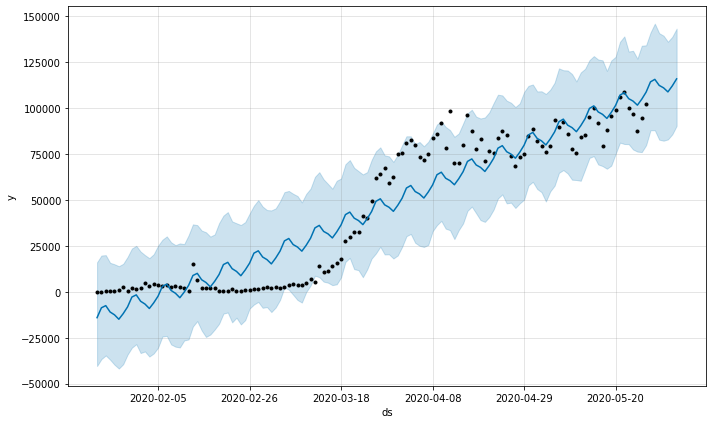

In [191]:
# Menampilkan hasil prediksi
confirmed_forecast_plot = m.plot(forecast)

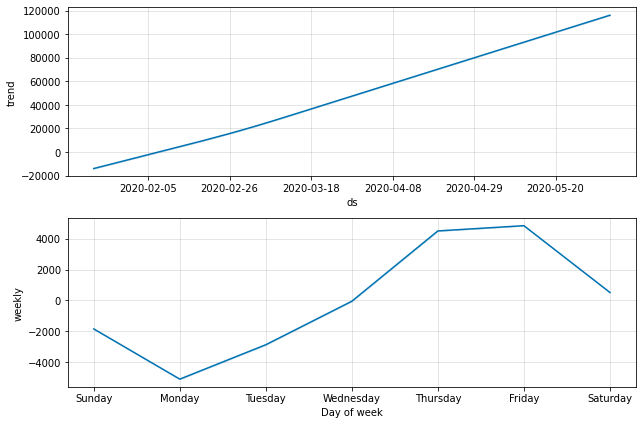

In [192]:
# Menampilkan komponen kecenderungan dari hasil prediksi
confirmed_forecast_plot =m.plot_components(forecast)

##2. Prediksi Kasus Deaths COVID-19 di Seluruh Dunia menggunakan Prophet (Base model)

Membangkitkan perkiraan satu minggu ke depan pada kasus yang meninggal dunia (deaths) COVID-19 menggunakan Prophet, dengan interval prediksi 95% dan menciptakan model dasar tanpa mengutak-atik parameter terkait seasonality-related dan additional regressors.

In [193]:
# Mengganti tabel Deaths pada kolom 'Date' menjadi 'ds' dan 'Deaths' menjadi 'y'
deaths.columns = ['ds','y']
deaths['ds'] = pd.to_datetime(deaths['ds'])

# Menambahkan tingkat kepercayaan di interval 0.95 dan memprediksi 7 hari ke depan dengan nama 'future'
m = Prophet(interval_width=0.95)
m.fit(deaths)
future = m.make_future_dataframe(periods=7)
future.tail(10)

#Memprediksi masa depan dengan tanggal, batas atas, batas bawah dan nilai y
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds         yhat   yhat_lower    yhat_upper
124 2020-05-25  5513.389773  2254.932904   8831.035930
125 2020-05-26  6412.785092  3272.770639   9471.954041
126 2020-05-27  6596.564399  3580.379407   9785.035544
127 2020-05-28  6627.578498  3656.072335   9792.564911
128 2020-05-29  6691.758923  3653.305200   9749.191900
129 2020-05-30  6315.662269  3114.570414   9476.731725
130 2020-05-31  5753.637692  2517.378928   8845.685823
131 2020-06-01  5864.876953  2872.170790   8960.979534
132 2020-06-02  6764.272272  3689.787214   9917.822194
133 2020-06-03  6948.051580  3883.186646  10037.831338

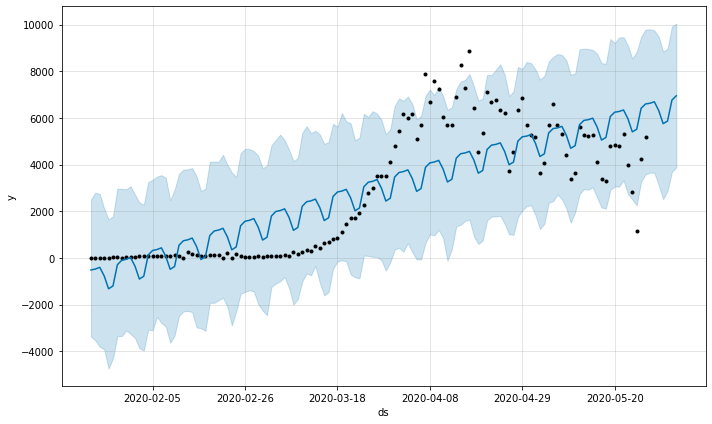

In [194]:
# Menampilkan hasil prediksi
deaths_forecast_plot = m.plot(forecast)

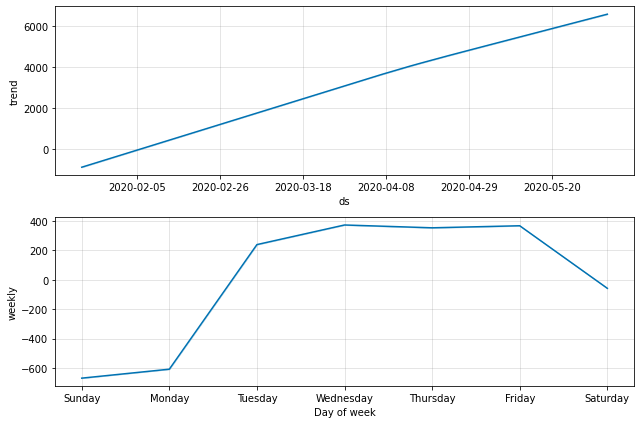

In [195]:
# Menampilkan komponen kecenderungan dari hasil prediksi
detahs_forecast_plot =m.plot_components(forecast)

##3. Prediksi Kasus Recovered COVID-19 di Seluruh Dunia menggunakan Prophet (Base model)

Membangkitkan perkiraan satu minggu ke depan pada kasus penyembuhan (recovered) COVID-19 menggunakan Prophet, dengan interval prediksi 95% dan menciptakan model dasar tanpa mengutak-atik parameter terkait seasonality-related dan additional regressors.

In [196]:
# Mengganti tabel Recovered pada kolom 'Date' menjadi 'ds' dan 'Recovered' menjadi 'y'
recovered.columns = ['ds','y']
recovered['ds'] = pd.to_datetime(recovered['ds'])

# Menambahkan tingkat kepercayaan di interval 0.95 dan memprediksi 7 hari ke depan dengan nama 'future'
m = Prophet(interval_width=0.95)
m.fit(deaths)
future = m.make_future_dataframe(periods=7)
future.tail(10)

#Memprediksi masa depan dengan tanggal, batas atas, batas bawah dan nilai y
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds         yhat   yhat_lower   yhat_upper
124 2020-05-25  5513.389773  2737.565937  8441.486653
125 2020-05-26  6412.785092  3203.714028  9546.530310
126 2020-05-27  6596.564399  3450.242617  9814.860904
127 2020-05-28  6627.578498  3551.128572  9876.921084
128 2020-05-29  6691.758923  3563.053654  9628.909218
129 2020-05-30  6315.662269  3441.859302  9471.259737
130 2020-05-31  5753.637692  2635.533141  8893.259948
131 2020-06-01  5864.876953  2627.805018  8792.382945
132 2020-06-02  6764.272272  3588.067563  9542.292700
133 2020-06-03  6948.051580  3671.556503  9988.290444

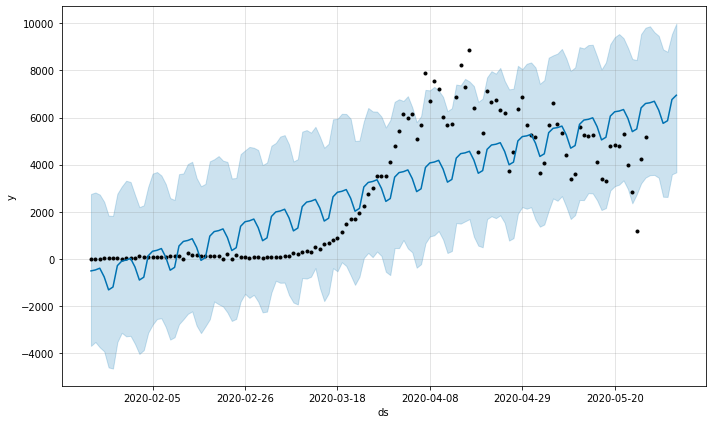

In [197]:
# Menampilkan hasil prediksi
recovered_forecast_plot = m.plot(forecast)

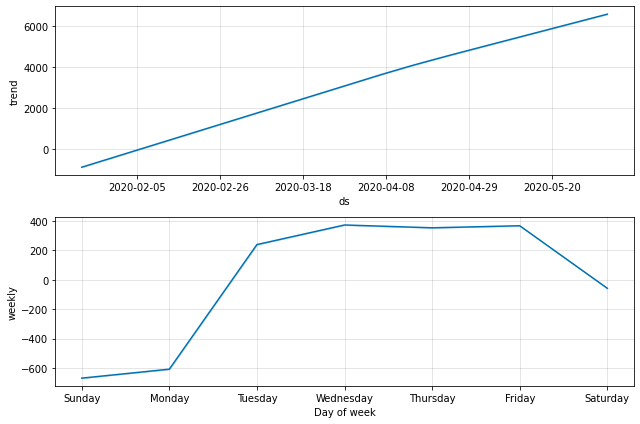

In [198]:
# Menampilkan komponen kecenderungan dari hasil prediksi
recovered_forecast_plot =m.plot_components(forecast)

# <h2><b>COVID-19 OVERVIEW</b></h2>

In [0]:
COL_REGION = 'Country/Region'
# Confirmed, Recovered, Deaths
df = get_frame('confirmed')
# dft_: timeseries, dfc_: today country agg
dft_cases = df
dft_deaths = get_frame('deaths')
dft_recovered = get_frame('recovered')
LAST_DATE_I, dt_cols = get_dates(df)

dt_today = dt_cols[LAST_DATE_I]
dt_5ago = dt_cols[LAST_DATE_I-5]


dfc_cases = dft_cases.groupby(COL_REGION)[dt_today].sum()
dfc_deaths = dft_deaths.groupby(COL_REGION)[dt_today].sum()
dfp_cases = dft_cases.groupby(COL_REGION)[dt_5ago].sum()
dfp_deaths = dft_deaths.groupby(COL_REGION)[dt_5ago].sum()

In [200]:
df_table = (pd.DataFrame(dict(Cases=dfc_cases, Deaths=dfc_deaths, PCases=dfp_cases, PDeaths=dfp_deaths))
             .sort_values(by=['Cases', 'Deaths'], ascending=[False, False])
             .reset_index())
df_table.rename(columns={'index': 'Country/Region'}, inplace=True)
for c in 'Cases, Deaths'.split(', '):
    df_table[f'{c} (+)'] = (df_table[c] - df_table[f'P{c}']).clip(0)  # DATA BUG
df_table['Fatality Rate'] = (100 * df_table['Deaths'] / df_table['Cases']).round(1)
df_table['Continent'] = df_table['Country/Region'].map(mapping['map.continent'])
df_table

Country/Region    Cases  ...  Fatality Rate      Continent
0                  US  1699176  ...            5.9  North America
1              Brazil   411821  ...            6.2  South America
2              Russia   370680  ...            1.1         Europe
3      United Kingdom   268619  ...           14.0         Europe
4               Spain   236259  ...           11.5         Europe
..                ...      ...  ...            ...            ...
183        Seychelles       11  ...            0.0         Africa
184        MS Zaandam        9  ...           22.2            NaN
185    Western Sahara        9  ...           11.1            NaN
186  Papua New Guinea        8  ...            0.0            NaN
187           Lesotho        2  ...            0.0            NaN

[188 rows x 9 columns]

In [0]:
# world, china, europe, us
metrics = ['Cases', 'Deaths', 'Cases (+)', 'Deaths (+)']
s_china = df_table[df_table['Country/Region'].eq('China')][metrics].sum().add_prefix('China ')
s_us = df_table[df_table['Country/Region'].eq('US')][metrics].sum().add_prefix('US ')
s_eu = df_table[df_table['Continent'].eq('Europe')][metrics].sum().add_prefix('EU ')
summary = {'updated': pd.to_datetime(dt_today), 'since': pd.to_datetime(dt_5ago)}
summary = {**summary, **df_table[metrics].sum(), **s_china, **s_us, **s_eu}


In [0]:
dft_ct_cases = dft_cases.groupby(COL_REGION)[dt_cols].sum()
dft_ct_new_cases = dft_ct_cases.diff(axis=1).fillna(0).astype(int)

In [203]:
template = Template(get_template(paths['overview']))
html = template.render(
    D=summary, table=df_table,  # REMOVE .head(20) to see all values
    newcases=dft_ct_new_cases.loc[:, dt_cols[LAST_DATE_I-jarak_waktu+1]:dt_cols[LAST_DATE_I]],
    np=np, pd=pd, enumerate=enumerate)
HTML(f'<div>{html}</div>')

<h3> Untuk lebih Jelasnya Hasil dari Overview COVID-19 ini dapat diakses Pada link berikut <a href="https://gramener.com/enumter/covid19/">https://gramener.com/enumter/covid19/</a></h3>